In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class MDP:
    '''A simple MDP class.  It includes the following members'''

    def __init__(self,T,R,discount):
        '''Constructor for the MDP class

        Inputs:
        T -- Transition function: |A| x |S| x |S'| array
        R -- Reward function: |A| x |S| array
        discount -- discount factor: scalar in [0,1)

        The constructor verifies that the inputs are valid and sets
        corresponding variables in a MDP object'''

        assert T.ndim == 3, "Invalid transition function: it should have 3 dimensions"
        self.nActions = T.shape[0]
        self.nStates = T.shape[1]
        assert T.shape == (self.nActions,self.nStates,self.nStates), "Invalid transition function: it has dimensionality " + repr(T.shape) + ", but it should be (nActions,nStates,nStates)"
        assert (abs(T.sum(2)-1) < 1e-5).all(), "Invalid transition function: some transition probability does not equal 1"
        self.T = T
        assert R.ndim == 2, "Invalid reward function: it should have 2 dimensions" 
        assert R.shape == (self.nActions,self.nStates), "Invalid reward function: it has dimensionality " + repr(R.shape) + ", but it should be (nActions,nStates)"
        self.R = R
        assert 0 <= discount < 1, "Invalid discount factor: it should be in [0,1)"
        self.discount = discount
        
    def valueIteration(self,initialV,nIterations=np.inf,tolerance=0.01):
        '''Value iteration procedure
        V <-- max_a R^a + gamma T^a V

        Inputs:
        initialV -- Initial value function: array of |S| entries
        nIterations -- limit on the # of iterations: scalar (default: infinity)
        tolerance -- threshold on ||V^n-V^n+1||_inf: scalar (default: 0.01)

        Outputs: 
        V -- Value function: array of |S| entries
        iterId -- # of iterations performed: scalar
        epsilon -- ||V^n-V^n+1||_inf: scalar'''
        
        # temporary values to ensure that the code compiles until this
        # function is coded
        V = initialV
        iterId = 0
        epsilon = np.inf
        
        while (iterId < nIterations and epsilon > tolerance):
          iterId += 1
          V_matrix = []
          for i in range(self.nActions):
            V_matrix.append(self.R[i]+self.discount*self.T[i] @ V)
          V_next = np.amax(np.array(V_matrix), 0)
          epsilon = np.max(np.abs(V_next - V))
          V = V_next
          
        return [V,iterId,epsilon]
          

    def extractPolicy(self,V):
        '''Procedure to extract a policy from a value function
        pi <-- argmax_a R^a + gamma T^a V

        Inputs:
        V -- Value function: array of |S| entries

        Output:
        policy -- Policy: array of |S| entries'''

        # temporary values to ensure that the code compiles until this
        # function is coded
        policy = np.zeros(self.nStates)
        
        V_matrix = []
        for i in range(self.nActions):
          V_matrix.append(self.R[i]+self.discount*self.T[i] @ V)
        policy = np.array(V_matrix).argmax(0)

        return policy 

    def evaluatePolicy(self,policy):
        '''Evaluate a policy by solving a system of linear equations
        V^pi = R^pi + gamma T^pi V^pi

        Input:
        policy -- Policy: array of |S| entries

        Ouput:
        V -- Value function: array of |S| entries'''

        # temporary values to ensure that the code compiles until this
        # function is coded
        V = np.zeros(self.nStates)
        
        R_pi = np.zeros(self.nStates)
        for i in range(self.nStates):
          R_pi[i] = self.R[policy[i]][i]
        
        T_pi = np.zeros([self.nStates,self.nStates])
        for i in range(self.nStates):
          T_pi[i] = self.T[policy[i]][i]
        
        V = np.linalg.pinv(np.identity(self.nStates) - self.discount*T_pi) @ R_pi

        return V
        
    def policyIteration(self,initialPolicy,nIterations=np.inf):
        '''Policy iteration procedure: alternate between policy
        evaluation (solve V^pi = R^pi + gamma T^pi V^pi) and policy
        improvement (pi <-- argmax_a R^a + gamma T^a V^pi).

        Inputs:
        initialPolicy -- Initial policy: array of |S| entries
        nIterations -- limit on # of iterations: scalar (default: inf)

        Outputs: 
        policy -- Policy: array of |S| entries
        V -- Value function: array of |S| entries
        iterId -- # of iterations peformed by modified policy iteration: scalar
        epsilon -- ||V^n-V^n+1||_inf: scalar'''

        # temporary values to ensure that the code compiles until this
        # function is coded
        policy = initialPolicy
        V = np.zeros(self.nStates)
        iterId = 0
        
        while(iterId < nIterations):
          iterId += 1
          V = self.evaluatePolicy(policy)
          policy_next = self.extractPolicy(V)
          if np.array_equal(policy, policy_next):
            return [policy,V,iterId]
          policy = policy_next
          
        return [policy, V, iterId]
          
    def evaluatePolicyPartially(self,policy,initialV,nIterations=np.inf,tolerance=0.01):
        '''Partial policy evaluation:
        Repeat V^pi <-- R^pi + gamma T^pi V^pi

        Inputs:
        policy -- Policy: array of |S| entries
        initialV -- Initial value function: array of |S| entries
        nIterations -- limit on the # of iterations: scalar (default: infinity)
        tolerance -- threshold on ||V^n-V^n+1||_inf: scalar (default: 0.01)

        Outputs: 
        V -- Value function: array of |S| entries
        iterId -- # of iterations performed: scalar
        epsilon -- ||V^n-V^n+1||_inf: scalar'''

        # temporary values to ensure that the code compiles until this
        # function is coded
        V = initialV
        iterId = 0
        epsilon = np.inf
        
        R_pi = np.zeros(self.nStates)
        for i in range(self.nStates):
          R_pi[i] = self.R[policy[i]][i]
        
        T_pi = np.zeros([self.nStates,self.nStates])
        for i in range(self.nStates):
          T_pi[i] = self.T[policy[i]][i]
          
        while(iterId < nIterations and epsilon > tolerance):
          iterId += 1
          V_next = R_pi + self.discount*T_pi @ V
          epsilon = np.max(np.abs(V_next - V))
          V = V_next

        return [V,iterId,epsilon]

    def modifiedPolicyIteration(self,initialPolicy,initialV,nEvalIterations=5,nIterations=np.inf,tolerance=0.01):
        '''Modified policy iteration procedure: alternate between
        partial policy evaluation (repeat a few times V^pi <-- R^pi + gamma T^pi V^pi)
        and policy improvement (pi <-- argmax_a R^a + gamma T^a V^pi)

        Inputs:
        initialPolicy -- Initial policy: array of |S| entries
        initialV -- Initial value function: array of |S| entries
        nEvalIterations -- limit on # of iterations to be performed in each partial policy evaluation: scalar (default: 5)
        nIterations -- limit on # of iterations to be performed in modified policy iteration: scalar (default: inf)
        tolerance -- threshold on ||V^n-V^n+1||_inf: scalar (default: 0.01)

        Outputs: 
        policy -- Policy: array of |S| entries
        V -- Value function: array of |S| entries
        iterId -- # of iterations peformed by modified policy iteration: scalar
        epsilon -- ||V^n-V^n+1||_inf: scalar'''

        # temporary values to ensure that the code compiles until this
        # function is coded
        policy = initialPolicy
        V = initialV
        iterId = 0
        epsilon = np.inf
        
        while(iterId < nIterations and epsilon > tolerance):
          iterId += 1
          [V, _, _] = self.evaluatePolicyPartially(policy,V,nEvalIterations,tolerance=0.01)
          policy = self.extractPolicy(V)
          [V_next, _, _] = self.valueIteration(V,1)
          epsilon = np.max(np.abs(V_next - V))
          

        return [policy,V,iterId,epsilon]
        

In [5]:
''' Construct a simple maze MDP

  Grid world layout:

  ---------------------
  |  0 |  1 |  2 |  3 |
  ---------------------
  |  4 |  5 |  6 |  7 |
  ---------------------
  |  8 |  9 | 10 | 11 |
  ---------------------
  | 12 | 13 | 14 | 15 |
  ---------------------

  Goal state: 15 
  Bad state: 9
  End state: 16

  The end state is an absorbing state that the agent transitions 
  to after visiting the goal state.

  There are 17 states in total (including the end state) 
  and 4 actions (up, down, left, right).'''

# Transition function: |A| x |S| x |S'| array
T = np.zeros([4,17,17])
a = 0.8;  # intended move
b = 0.1;  # lateral move

# up (a = 0)

T[0,0,0] = a+b;
T[0,0,1] = b;

T[0,1,0] = b;
T[0,1,1] = a;
T[0,1,2] = b;

T[0,2,1] = b;
T[0,2,2] = a;
T[0,2,3] = b;

T[0,3,2] = b;
T[0,3,3] = a+b;

T[0,4,4] = b;
T[0,4,0] = a;
T[0,4,5] = b;

T[0,5,4] = b;
T[0,5,1] = a;
T[0,5,6] = b;

T[0,6,5] = b;
T[0,6,2] = a;
T[0,6,7] = b;

T[0,7,6] = b;
T[0,7,3] = a;
T[0,7,7] = b;

T[0,8,8] = b;
T[0,8,4] = a;
T[0,8,9] = b;

T[0,9,8] = b;
T[0,9,5] = a;
T[0,9,10] = b;

T[0,10,9] = b;
T[0,10,6] = a;
T[0,10,11] = b;

T[0,11,10] = b;
T[0,11,7] = a;
T[0,11,11] = b;

T[0,12,12] = b;
T[0,12,8] = a;
T[0,12,13] = b;

T[0,13,12] = b;
T[0,13,9] = a;
T[0,13,14] = b;

T[0,14,13] = b;
T[0,14,10] = a;
T[0,14,15] = b;

T[0,15,16] = 1;
T[0,16,16] = 1;

# down (a = 1)

T[1,0,0] = b;
T[1,0,4] = a;
T[1,0,1] = b;

T[1,1,0] = b;
T[1,1,5] = a;
T[1,1,2] = b;

T[1,2,1] = b;
T[1,2,6] = a;
T[1,2,3] = b;

T[1,3,2] = b;
T[1,3,7] = a;
T[1,3,3] = b;

T[1,4,4] = b;
T[1,4,8] = a;
T[1,4,5] = b;

T[1,5,4] = b;
T[1,5,9] = a;
T[1,5,6] = b;

T[1,6,5] = b;
T[1,6,10] = a;
T[1,6,7] = b;

T[1,7,6] = b;
T[1,7,11] = a;
T[1,7,7] = b;

T[1,8,8] = b;
T[1,8,12] = a;
T[1,8,9] = b;

T[1,9,8] = b;
T[1,9,13] = a;
T[1,9,10] = b;

T[1,10,9] = b;
T[1,10,14] = a;
T[1,10,11] = b;

T[1,11,10] = b;
T[1,11,15] = a;
T[1,11,11] = b;

T[1,12,12] = a+b;
T[1,12,13] = b;

T[1,13,12] = b;
T[1,13,13] = a;
T[1,13,14] = b;

T[1,14,13] = b;
T[1,14,14] = a;
T[1,14,15] = b;

T[1,15,16] = 1;
T[1,16,16] = 1;

# left (a = 2)

T[2,0,0] = a+b;
T[2,0,4] = b;

T[2,1,1] = b;
T[2,1,0] = a;
T[2,1,5] = b;

T[2,2,2] = b;
T[2,2,1] = a;
T[2,2,6] = b;

T[2,3,3] = b;
T[2,3,2] = a;
T[2,3,7] = b;

T[2,4,0] = b;
T[2,4,4] = a;
T[2,4,8] = b;

T[2,5,1] = b;
T[2,5,4] = a;
T[2,5,9] = b;

T[2,6,2] = b;
T[2,6,5] = a;
T[2,6,10] = b;

T[2,7,3] = b;
T[2,7,6] = a;
T[2,7,11] = b;

T[2,8,4] = b;
T[2,8,8] = a;
T[2,8,12] = b;

T[2,9,5] = b;
T[2,9,8] = a;
T[2,9,13] = b;

T[2,10,6] = b;
T[2,10,9] = a;
T[2,10,14] = b;

T[2,11,7] = b;
T[2,11,10] = a;
T[2,11,15] = b;

T[2,12,8] = b;
T[2,12,12] = a+b;

T[2,13,9] = b;
T[2,13,12] = a;
T[2,13,13] = b;

T[2,14,10] = b;
T[2,14,13] = a;
T[2,14,14] = b;

T[2,15,16] = 1;
T[2,16,16] = 1;

# right (a = 3)

T[3,0,0] = b;
T[3,0,1] = a;
T[3,0,4] = b;

T[3,1,1] = b;
T[3,1,2] = a;
T[3,1,5] = b;

T[3,2,2] = b;
T[3,2,3] = a;
T[3,2,6] = b;

T[3,3,3] = a+b;
T[3,3,7] = b;

T[3,4,0] = b;
T[3,4,5] = a;
T[3,4,8] = b;

T[3,5,1] = b;
T[3,5,6] = a;
T[3,5,9] = b;

T[3,6,2] = b;
T[3,6,7] = a;
T[3,6,10] = b;

T[3,7,3] = b;
T[3,7,7] = a;
T[3,7,11] = b;

T[3,8,4] = b;
T[3,8,9] = a;
T[3,8,12] = b;

T[3,9,5] = b;
T[3,9,10] = a;
T[3,9,13] = b;

T[3,10,6] = b;
T[3,10,11] = a;
T[3,10,14] = b;

T[3,11,7] = b;
T[3,11,11] = a;
T[3,11,15] = b;

T[3,12,8] = b;
T[3,12,13] = a;
T[3,12,12] = b;

T[3,13,9] = b;
T[3,13,14] = a;
T[3,13,13] = b;

T[3,14,10] = b;
T[3,14,15] = a;
T[3,14,14] = b;

T[3,15,16] = 1;
T[3,16,16] = 1;

# Reward function: |A| x |S| array
R = -1 * np.ones([4,17]);

# set rewards
R[:,15] = 100;  # goal state
R[:,9] = -70;   # bad state
R[:,16] = 0;    # end state

# Discount factor: scalar in [0,1)
discount = 0.95
        
# MDP object
mdp = MDP(T,R,discount)

Value Iteration:
Value function [ 60.62388836  66.03486523  71.80422632  77.09196339  59.81429704
  65.18237783  77.83066489  84.14118981  58.09361039   7.98780239
  84.86704922  91.78159355  69.49584217  76.80962081  91.78159355
 100.           0.        ]
Number of Iteration 20
Policy [3 3 3 1 3 3 3 1 1 3 3 1 3 3 3 0 0]

Policy Iteration:
Value function [ 6.06325617e+01  6.60389743e+01  7.18062328e+01  7.70929558e+01
  5.98194517e+01  6.51845768e+01  7.78315190e+01  8.41414906e+01
  5.80955782e+01  7.98862928e+00  8.48673058e+01  9.17816509e+01
  6.94968138e+01  7.68099165e+01  9.17816509e+01  1.00000000e+02
 -1.22642244e-13]
Number of Iteration 5
Policy [3 3 3 1 3 3 3 1 1 3 3 1 3 3 3 0 0]

Modified Policy Iteration:
Value function [ 60.62620571  66.03589918  71.80476451  77.09221195  59.8155468
  65.18298577  77.83087408  84.14127199  58.09416596   7.98799728
  84.8671211   91.78160747  69.4960893   76.80970295  91.78160747
 100.           0.        ]
Number of Iteration 6
Policy [3

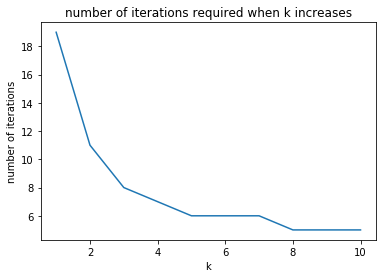

In [6]:
'''Test each procedure'''
[V,nIterations,epsilon] = mdp.valueIteration(initialV=np.zeros(mdp.nStates),tolerance=0.01)
policy = mdp.extractPolicy(V)
print("Value Iteration:\nValue function {}\nNumber of Iteration {}\nPolicy {}\n".format(V,nIterations,policy))
#V = mdp.evaluatePolicy(np.array([1,0,1,0]))
[policy,V,iterId] = mdp.policyIteration(np.zeros(mdp.nStates,dtype=int))
print("Policy Iteration:\nValue function {}\nNumber of Iteration {}\nPolicy {}\n".format(V,iterId,policy))
#[V,iterId,epsilon] = mdp.evaluatePolicyPartially(np.array([1,0,1,0]),np.array([0,10,0,13]))

[policy,V,iterId,tolerance] = mdp.modifiedPolicyIteration(np.zeros(mdp.nStates,dtype=int),np.zeros(mdp.nStates),tolerance=0.01)
print("Modified Policy Iteration:\nValue function {}\nNumber of Iteration {}\nPolicy {}\n".format(V,iterId,policy))

iterId_lst=[]
for i in range(10):
  [_,_,iterId,_] = mdp.modifiedPolicyIteration(np.zeros(mdp.nStates,dtype=np.int),np.zeros(mdp.nStates),nEvalIterations=i+1)
  iterId_lst.append(iterId)
  
plt.title("number of iterations required when k increases")
plt.xlabel("k")
plt.ylabel("number of iterations")
_=plt.plot(np.arange(10)+1, iterId_lst)


## Analysis for the impact of the number of iterations in partial policy evaluation on the results
As the number of iterations in partial policy evaluation increases, the modified policy iteration converges faster but the rate slows down and eventaully reaches a plain. when k is small the modified policy iteration approaches value iteration and when k is large, the modified policy iteration approaches policy iteration as the partial policy evaluation approaches true policy evaluation of policy iteration.

In [9]:
class RL:
    def __init__(self,mdp,sampleReward):
        '''Constructor for the RL class

        Inputs:
        mdp -- Markov decision process (T, R, discount)
        sampleReward -- Function to sample rewards (e.g., bernoulli, Gaussian).
        This function takes one argument: the mean of the distributon and 
        returns a sample from the distribution.
        '''

        self.mdp = mdp
        self.sampleReward = sampleReward

    def sampleRewardAndNextState(self,state,action):
        '''Procedure to sample a reward and the next state
        reward ~ Pr(r)
        nextState ~ Pr(s'|s,a)

        Inputs:
        state -- current state
        action -- action to be executed

        Outputs: 
        reward -- sampled reward
        nextState -- sampled next state
        '''

        reward = self.sampleReward(self.mdp.R[action,state])
        cumProb = np.cumsum(self.mdp.T[action,state,:])
        nextState = np.where(cumProb >= np.random.rand(1))[0][0]
        return [reward,nextState]

    def qLearning(self,s0,initialQ,nEpisodes,nSteps,epsilon=0,temperature=1):
        '''qLearning algorithm.  Epsilon exploration and Boltzmann exploration
        are combined in one procedure by sampling a random action with 
        probabilty epsilon and performing Boltzmann exploration otherwise.  
        When epsilon and temperature are set to 0, there is no exploration.

        Inputs:
        s0 -- initial state
        initialQ -- initial Q function (|A|x|S| array)
        nEpisodes -- # of episodes (one episode consists of a trajectory of nSteps that starts in s0
        nSteps -- # of steps per episode
        epsilon -- probability with which an action is chosen at random
        temperature -- parameter that regulates Boltzmann exploration

        Outputs: 
        Q -- final Q function (|A|x|S| array)
        policy -- final policy
        '''

        # temporary values to ensure that the code compiles until this
        # function is coded
        Q = initialQ
        n_table = np.zeros(Q.shape,dtype=int)
        learning_rate = 0
        episodeId = 0
        reward_episodes = []
        while (episodeId < nEpisodes):
          episodeId += 1
          s=s0
          reward_cum=0
          stepId = 0
          discount_factor = 1
          while (stepId < nSteps):
            stepId += 1
            action = 0
            discount_factor *= self.mdp.discount
            if (np.random.rand(1) < epsilon):
              action = np.random.randint(self.mdp.nActions)
            elif (temperature != 0):
              boltz_state = np.exp(Q[:,s].flatten() / temperature)
              boltz_state = boltz_state / boltz_state.sum()
              boltz_state = np.cumsum(boltz_state)
              action = np.where(boltz_state >= np.random.rand(1))[0][0]
            else:
              action = Q[:,s].argmax()
              print (action)
            [reward, s_next] = self.sampleRewardAndNextState(s,action)
            n_table[action,s] += 1
            learning_rate = 1 / n_table[action,s]
            Q[action,s] = Q[action,s] + learning_rate*(reward + self.mdp.discount*np.max(Q[:,s_next].flatten())-Q[action,s])
            s = s_next
            reward_cum += discount_factor * reward
          reward_episodes.append(reward_cum)
        
        policy = Q.argmax(0).flatten()

        return [Q,policy, reward_episodes]    

----------------------------------------------------------------------------------------------------
[3 3 1 2 3 0 1 1 2 3 1 2 3 1 3 2 0]
----------------------------------------------------------------------------------------------------
[3 3 1 1 3 3 3 1 2 3 3 1 2 1 3 2 3]
----------------------------------------------------------------------------------------------------
[1 3 3 1 1 3 1 1 1 3 3 1 3 3 3 1 2]
----------------------------------------------------------------------------------------------------
[3 3 1 1 3 3 1 1 2 3 3 1 3 3 3 2 3]


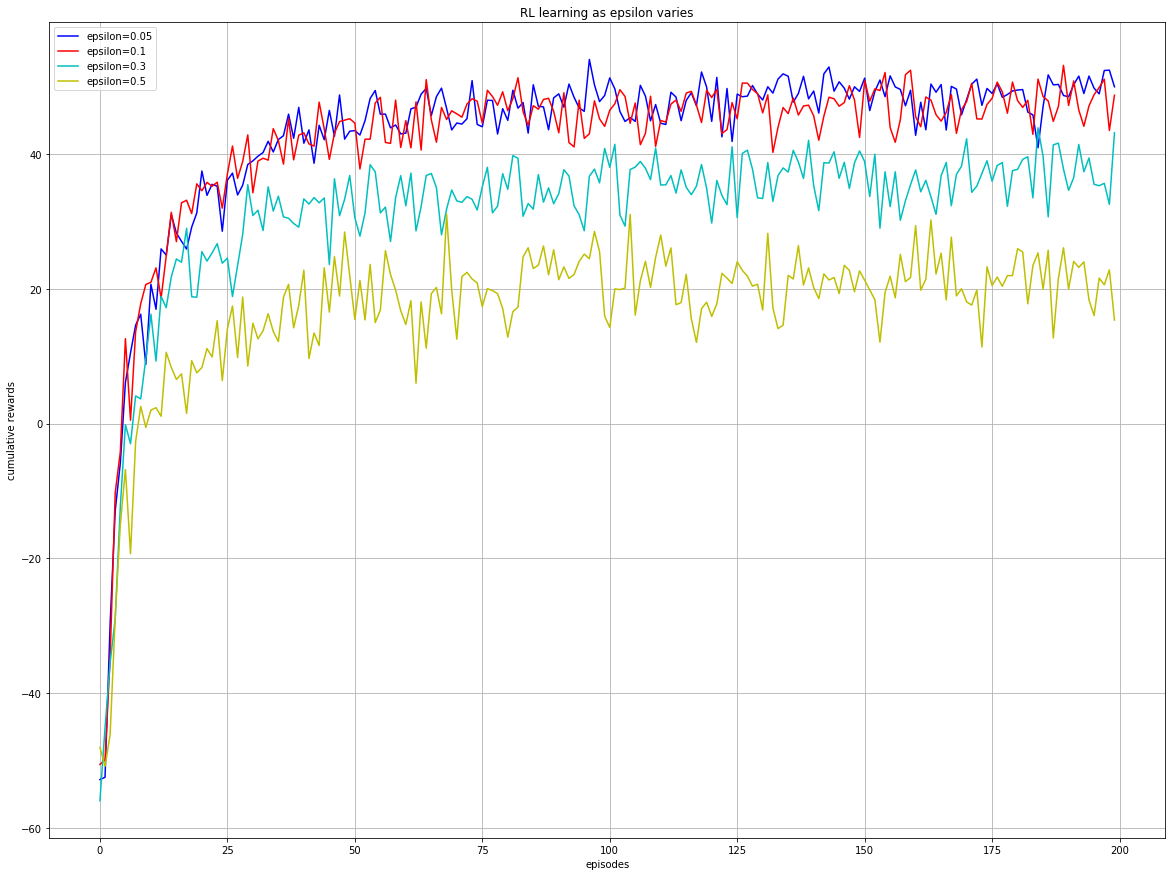

In [10]:


import sys

''' Construct a simple maze MDP

  Grid world layout:

  ---------------------
  |  0 |  1 |  2 |  3 |
  ---------------------
  |  4 |  5 |  6 |  7 |
  ---------------------
  |  8 |  9 | 10 | 11 |
  ---------------------
  | 12 | 13 | 14 | 15 |
  ---------------------

  Goal state: 15 
  Bad state: 9
  End state: 16

  The end state is an absorbing state that the agent transitions 
  to after visiting the goal state.

  There are 17 states in total (including the end state) 
  and 4 actions (up, down, left, right).'''

# Transition function: |A| x |S| x |S'| array
T = np.zeros([4,17,17])
a = 0.8;  # intended move
b = 0.1;  # lateral move

# up (a = 0)

T[0,0,0] = a+b;
T[0,0,1] = b;

T[0,1,0] = b;
T[0,1,1] = a;
T[0,1,2] = b;

T[0,2,1] = b;
T[0,2,2] = a;
T[0,2,3] = b;

T[0,3,2] = b;
T[0,3,3] = a+b;

T[0,4,4] = b;
T[0,4,0] = a;
T[0,4,5] = b;

T[0,5,4] = b;
T[0,5,1] = a;
T[0,5,6] = b;

T[0,6,5] = b;
T[0,6,2] = a;
T[0,6,7] = b;

T[0,7,6] = b;
T[0,7,3] = a;
T[0,7,7] = b;

T[0,8,8] = b;
T[0,8,4] = a;
T[0,8,9] = b;

T[0,9,8] = b;
T[0,9,5] = a;
T[0,9,10] = b;

T[0,10,9] = b;
T[0,10,6] = a;
T[0,10,11] = b;

T[0,11,10] = b;
T[0,11,7] = a;
T[0,11,11] = b;

T[0,12,12] = b;
T[0,12,8] = a;
T[0,12,13] = b;

T[0,13,12] = b;
T[0,13,9] = a;
T[0,13,14] = b;

T[0,14,13] = b;
T[0,14,10] = a;
T[0,14,15] = b;

T[0,15,16] = 1;
T[0,16,16] = 1;

# down (a = 1)

T[1,0,0] = b;
T[1,0,4] = a;
T[1,0,1] = b;

T[1,1,0] = b;
T[1,1,5] = a;
T[1,1,2] = b;

T[1,2,1] = b;
T[1,2,6] = a;
T[1,2,3] = b;

T[1,3,2] = b;
T[1,3,7] = a;
T[1,3,3] = b;

T[1,4,4] = b;
T[1,4,8] = a;
T[1,4,5] = b;

T[1,5,4] = b;
T[1,5,9] = a;
T[1,5,6] = b;

T[1,6,5] = b;
T[1,6,10] = a;
T[1,6,7] = b;

T[1,7,6] = b;
T[1,7,11] = a;
T[1,7,7] = b;

T[1,8,8] = b;
T[1,8,12] = a;
T[1,8,9] = b;

T[1,9,8] = b;
T[1,9,13] = a;
T[1,9,10] = b;

T[1,10,9] = b;
T[1,10,14] = a;
T[1,10,11] = b;

T[1,11,10] = b;
T[1,11,15] = a;
T[1,11,11] = b;

T[1,12,12] = a+b;
T[1,12,13] = b;

T[1,13,12] = b;
T[1,13,13] = a;
T[1,13,14] = b;

T[1,14,13] = b;
T[1,14,14] = a;
T[1,14,15] = b;

T[1,15,16] = 1;
T[1,16,16] = 1;

# left (a = 2)

T[2,0,0] = a+b;
T[2,0,4] = b;

T[2,1,1] = b;
T[2,1,0] = a;
T[2,1,5] = b;

T[2,2,2] = b;
T[2,2,1] = a;
T[2,2,6] = b;

T[2,3,3] = b;
T[2,3,2] = a;
T[2,3,7] = b;

T[2,4,0] = b;
T[2,4,4] = a;
T[2,4,8] = b;

T[2,5,1] = b;
T[2,5,4] = a;
T[2,5,9] = b;

T[2,6,2] = b;
T[2,6,5] = a;
T[2,6,10] = b;

T[2,7,3] = b;
T[2,7,6] = a;
T[2,7,11] = b;

T[2,8,4] = b;
T[2,8,8] = a;
T[2,8,12] = b;

T[2,9,5] = b;
T[2,9,8] = a;
T[2,9,13] = b;

T[2,10,6] = b;
T[2,10,9] = a;
T[2,10,14] = b;

T[2,11,7] = b;
T[2,11,10] = a;
T[2,11,15] = b;

T[2,12,8] = b;
T[2,12,12] = a+b;

T[2,13,9] = b;
T[2,13,12] = a;
T[2,13,13] = b;

T[2,14,10] = b;
T[2,14,13] = a;
T[2,14,14] = b;

T[2,15,16] = 1;
T[2,16,16] = 1;

# right (a = 3)

T[3,0,0] = b;
T[3,0,1] = a;
T[3,0,4] = b;

T[3,1,1] = b;
T[3,1,2] = a;
T[3,1,5] = b;

T[3,2,2] = b;
T[3,2,3] = a;
T[3,2,6] = b;

T[3,3,3] = a+b;
T[3,3,7] = b;

T[3,4,0] = b;
T[3,4,5] = a;
T[3,4,8] = b;

T[3,5,1] = b;
T[3,5,6] = a;
T[3,5,9] = b;

T[3,6,2] = b;
T[3,6,7] = a;
T[3,6,10] = b;

T[3,7,3] = b;
T[3,7,7] = a;
T[3,7,11] = b;

T[3,8,4] = b;
T[3,8,9] = a;
T[3,8,12] = b;

T[3,9,5] = b;
T[3,9,10] = a;
T[3,9,13] = b;

T[3,10,6] = b;
T[3,10,11] = a;
T[3,10,14] = b;

T[3,11,7] = b;
T[3,11,11] = a;
T[3,11,15] = b;

T[3,12,8] = b;
T[3,12,13] = a;
T[3,12,12] = b;

T[3,13,9] = b;
T[3,13,14] = a;
T[3,13,13] = b;

T[3,14,10] = b;
T[3,14,15] = a;
T[3,14,14] = b;

T[3,15,16] = 1;
T[3,16,16] = 1;

# Reward function: |A| x |S| array
R = -1 * np.ones([4,17]);

# set rewards
R[:,15] = 100;  # goal state
R[:,9] = -70;   # bad state
R[:,16] = 0;    # end state

# Discount factor: scalar in [0,1)
discount = 0.95
        
# MDP object
mdp = MDP(T,R,discount)

# RL problem
rlProblem = RL(mdp,np.random.normal)

# Test Q-learning
plt.figure(figsize=(20,15))
history_lst=[]
policy = []
for i in range(100):
  print('-',end='')
  [Q,policy,history] = rlProblem.qLearning(s0=0,initialQ=np.zeros([mdp.nActions,mdp.nStates]),nEpisodes=200,nSteps=100,epsilon=0.05)
  history_lst.append(history)
_=plt.plot(range(200),np.average(history_lst,axis=0),'-b', label='epsilon=0.05')
print()
print(policy)

history_lst=[]
for i in range(100):
  print('-',end='')
  [Q,policy,history] = rlProblem.qLearning(s0=0,initialQ=np.zeros([mdp.nActions,mdp.nStates]),nEpisodes=200,nSteps=100,epsilon=0.1)
  history_lst.append(history)
_=plt.plot(range(200),np.average(history_lst,axis=0),'-r', label='epsilon=0.1')
print()
print(policy)

history_lst=[]
for i in range(100):
  print('-',end='')
  [Q,policy,history] = rlProblem.qLearning(s0=0,initialQ=np.zeros([mdp.nActions,mdp.nStates]),nEpisodes=200,nSteps=100,epsilon=0.3)
  history_lst.append(history)
_=plt.plot(range(200),np.average(history_lst,axis=0),'-c', label='epsilon=0.3')
print()
print(policy)

history_lst=[]
for i in range(100):
  print('-',end='')
  [Q,policy,history] = rlProblem.qLearning(s0=0,initialQ=np.zeros([mdp.nActions,mdp.nStates]),nEpisodes=200,nSteps=100,epsilon=0.5)
  history_lst.append(history)
_=plt.plot(range(200),np.average(history_lst,axis=0),'-y', label='epsilon=0.5')
print()
print(policy)

plt.legend()
plt.xlabel("episodes")
plt.ylabel("cumulative rewards")
plt.title("RL learning as epsilon varies")
plt.grid()
plt.show()


## The impact of the exploration probability epsilon on the cumulative rewards per episode earned during training
As shown in the graph above, the cumulative rewards of models with different epsilons converge at almost the same time. But the model with larger epsilon keep exploring more after convergence resulting in the larger variance in the cumulative rewards after convergence. This exploration also leads to larger bias as the number of episodes is still not large enough and the mode with larger epsilon tends to execute actions which give smaller rewards. The cumulative reward is also a good indicator of the Q values during learning as the convergence of Q values results in the convergence of policy and thus the rewards obtained in a stochastic manner.
Since the resulting policies are different as epsilon varies, one can infer that the Q vaules are still not optimal as otherwise they would give the same optimal policy. My guess after enough episodes would be that all the four models of different epsilons will converge to the same policy as they all have some sort of exploration.

In [17]:
!pip install gym

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [18]:
import gym
env = gym.make('CartPole-v0')
env.reset()
for _ in range(100):
    env.render()
    env.step(env.action_space.sample()) # take a random action
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


In [20]:
# %%writefile cart.py
# %load cart.py
import gym
import itertools
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as layers

import baselines.common.tf_util as U

from baselines import logger
from baselines import deepq
from baselines.deepq.replay_buffer import ReplayBuffer
from baselines.deepq.utils import ObservationInput
from baselines.common.schedules import LinearSchedule


def model(inpt, num_actions, scope, reuse=False):
    """This model takes as input an observation and returns values of all actions."""
    with tf.variable_scope(scope, reuse=reuse):
        out = inpt
        out = layers.fully_connected(out, num_outputs=64, activation_fn=tf.nn.tanh)
        out = layers.fully_connected(out, num_outputs=num_actions, activation_fn=None)
        return out


def cart(target_update_steps=1000, minibatch_size=32):
    tf.reset_default_graph()
    with U.make_session(8):
        # Create the environment
        env = gym.make("CartPole-v0")
        # Create all the functions necessary to train the model
        act, train, update_target, debug = deepq.build_train(
            make_obs_ph=lambda name: ObservationInput(env.observation_space, name=name),
            q_func=model,
            num_actions=env.action_space.n,
            optimizer=tf.train.AdamOptimizer(learning_rate=5e-4),
        )
        # Create the replay buffer
        replay_buffer = ReplayBuffer(50000)
        # Create the schedule for exploration starting from 1 (every action is random) down to
        # 0.02 (98% of actions are selected according to values predicted by the model).
        exploration = LinearSchedule(schedule_timesteps=10000, initial_p=1.0, final_p=0.02)

        # Initialize the parameters and copy them to the target network.
        U.initialize()
        update_target()

        episode_rewards = [0.0]
        obs = env.reset()
        for t in itertools.count():
            # Take action and update exploration to the newest value
            action = act(obs[None], update_eps=exploration.value(t))[0]
            new_obs, rew, done, _ = env.step(action)
            # Store transition in the replay buffer.
            replay_buffer.add(obs, action, rew, new_obs, float(done))
            obs = new_obs

            episode_rewards[-1] += rew
            if done:
                obs = env.reset()
                episode_rewards.append(0)

            is_solved = t > 100 and np.mean(episode_rewards[-101:-1]) >= 200
            if is_solved:
                pass
                # Show off the result
                #env.render()
            else:
                # Minimize the error in Bellman's equation on a batch sampled from replay buffer.
                if t > 1000:
                    obses_t, actions, rewards, obses_tp1, dones = replay_buffer.sample(minibatch_size)
                    train(obses_t, actions, rewards, obses_tp1, dones, np.ones_like(rewards))
                # Update target network periodically.
                if t % target_update_steps == 0:
                    update_target()

            if done and len(episode_rewards) % 10 == 0:
                logger.record_tabular("steps", t)
                logger.record_tabular("episodes", len(episode_rewards))
                logger.record_tabular("mean episode reward", round(np.mean(episode_rewards[-101:-1]), 1))
                logger.record_tabular("% time spent exploring", int(100 * exploration.value(t)))
                #logger.dump_tabular()
            if (len(episode_rewards) == 1001):
                return episode_rewards[:1000]


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


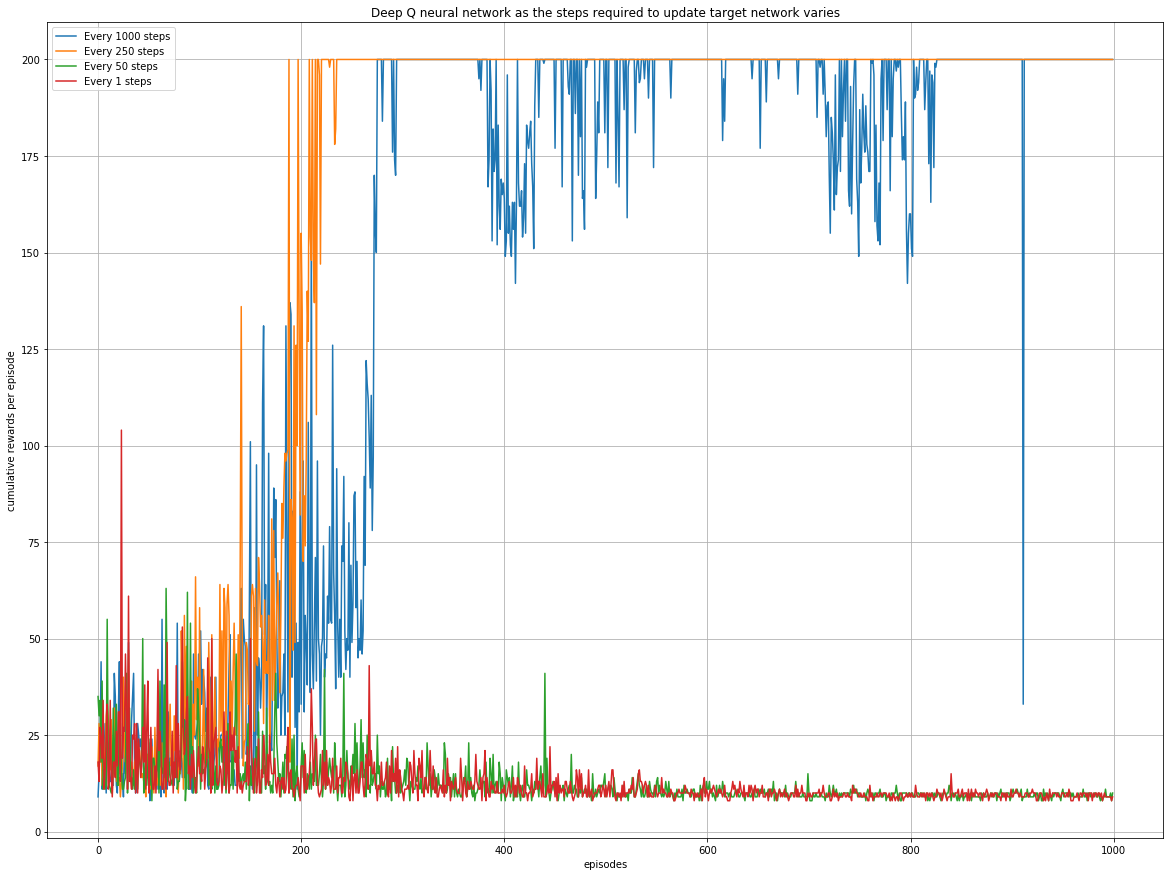

In [21]:
plt.figure(figsize=(20,15))
for target_update_steps in [1000,250,50,1]:
    history=cart(target_update_steps=target_update_steps)
    _=plt.plot(range(1000),history, label='Every {} steps'.format(target_update_steps))
plt.legend()
plt.grid()
plt.title("Deep Q neural network as the steps required to update target network varies")
plt.xlabel("episodes")
plt.ylabel("cumulative rewards per episode")
plt.show()

## The impact of the target network compared with value iteration
* The target neural network mitigates the divergence of the deep Q learning as it stays the same for 'most' of the time and only gets updated periodically. 
* As the target neural network gets updated more often, the deep Q learning algorithm with target network approaches value iteration with the two networks being essentially the same when the target network updating step is set to 1. But value iteration on a deep neural network might diverge and this could explain the poor performance of the models above when we update the target network too often namely every 1 or 50 steps. These two models can only obtain cumulative rewards close to zero because the model learnt does not converge and choose the action in each step almost at random. The reason why naive value based Q learning does not work lies in that adjusting the parameters of deep neural network might introduce errors at nearby state-action pairs. When the target network is updated every 250 or 1000 steps, the Q values would be more likely to converge as the target network stays the same most of the time. As shown above, when the update step is set to 250 or 1000 the models converge to make decisions that obtain much more cumulative rewards than random selection. The reason that step 250 converges faster than 1000 is that given the models would converge, updating the parameters of the neural network more often makes the gradient descent algorithm more efficiently and leads to the optimal Q value faster.

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


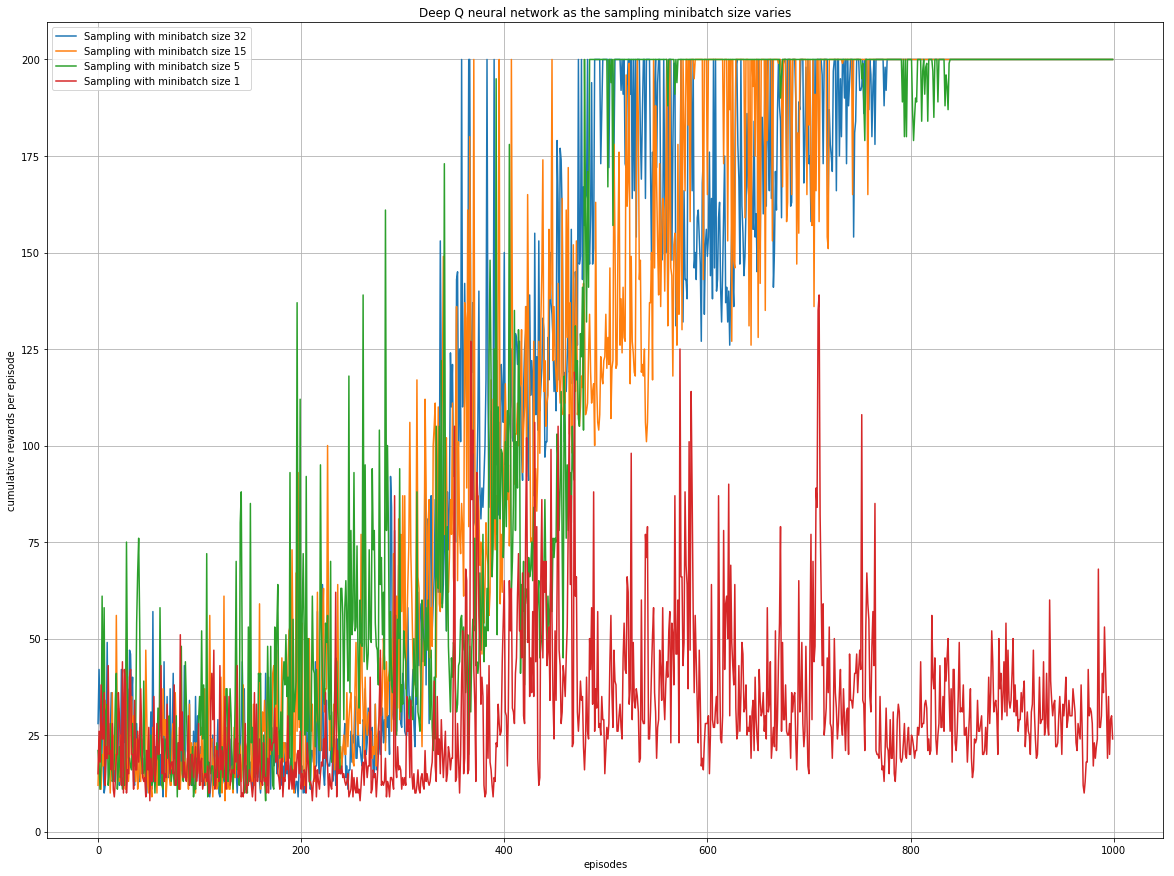

In [23]:
plt.figure(figsize=(20,15))
for minibatch_size in [32,15,5,1]:
    history=cart(minibatch_size=minibatch_size)
    _=plt.plot(range(1000),history, label='Sampling with minibatch size {}'.format(minibatch_size))
plt.legend()
plt.grid()
plt.title("Deep Q neural network as the sampling minibatch size varies")
plt.xlabel("episodes")
plt.ylabel("cumulative rewards per episode")
plt.show()

## Impact of the replay buffer
* As mentioned early, deep Q learning might diverge due to the fact that updating the parameters of a deep neural network might introduce new errors at nearby state-action pairs. Sampling state-action-state-reward quadruples from minibatches enables the neural network to learn from experience and thus reduce the error introduced by nearby state action updates. It also breaks the correlations between consecutive state action pairs and make the model more stable and mitigate divergence. Besides, it speeds up the convergence as in each step, multiple state action pairs are sampled from the experience and then used to update the network. Compared to exact gradient descent, the replay buffer enables the model to learn from experience with lower computational complexity for each step.
* As shown above, as the size of the minibatch increases the model converges faster and faster with the exception that sampling size 15 beats size 32. This could be explained by the above analysis and the exception might be that at the beginning the model makes many bad decisions which then get sampled by the following learning process. Therefore the larger minibatch size might introduce more noise within 1000 episodes. However, this noise must decreases as the model learns more episodes and make more good actions.